In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
path_of_input_image_classes = 'dataset'
class_names = os.listdir(path_of_input_image_classes)

In [3]:
ROWS = 200
COLS = 200
CHANNELS = 3

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prepare_data(images, classe):
    m = len(images)
    X = np.zeros((m, ROWS, COLS, CHANNELS), dtype=np.uint8)
    y = np.zeros(m, dtype=np.uint8) # Initialize all output values with 0
    for i, image_file in enumerate(images):
        X[i] = read_image(image_file)
        if classe[i] == 'broadleaf':
            y[i] = 0
        elif classe[i] == 'grass':
            y[i] = 1
        elif classe[i] == 'soil':
            y[i] = 2
        elif classe[i] == 'soybean':
            y[i] = 3
        
    return X, y



In [6]:
# Select random x and y train data
def splitTrainTestData(X, Y, size_test, size_val):
    train_indexes = np.random.permutation(X.shape[0])
    #train_X = X[0:int(len(X)*(1-(size_test+size_val)))]
    #train_Y = Y[0:int(len(Y)*(1-(size_test+size_val)))]
    #test_X = X[len(train_X):len(train_X)+int(len(X)*size_test)]
    #test_Y = Y[len(train_Y):len(train_X)+int(len(X)*size_test)]
    #val_X = X[len(train_X) + len(test_X):]
    #val_Y = Y[len(train_X) + len(test_Y):]
    train_X = X[train_indexes[0:int(len(X)*(1-(size_test+size_val)))]]
    train_Y = Y[train_indexes[0:int(len(Y)*(1-(size_test+size_val)))]]
    test_X = X[train_indexes[len(train_X):len(train_X)+int(len(X)*size_test)]]
    test_Y = Y[train_indexes[len(train_Y):len(train_X)+int(len(X)*size_test)]]
    val_X = X[train_indexes[len(train_X) + len(test_X):]]
    val_Y = Y[train_indexes[len(train_X) + len(test_Y):]]
    
    print('Train size: {} - Test size {} - Val size {}'.format(len(train_X), len(test_X), len(val_X)))
    
    return train_X, train_Y, test_X, test_Y, val_X, val_Y

In [18]:
list_images = []
list_classes = []
num_of_images_in_classes = 1000

for dir in class_names:
    filenames = os.listdir(os.path.join(path_of_input_image_classes,dir))
    

    for file in filenames[0:num_of_images_in_classes]:
        list_images.append(os.path.join(path_of_input_image_classes, dir, file))
        list_classes.append(dir)
        
    print('Classe: {} - Images: {}'.format(dir, len(filenames)))
    
X,y = prepare_data(list_images, list_classes)
print('Amostras: {} - Labels: {}'.format(len(X), len(y)))

Classe: broadleaf - Images: 1191
Classe: grass - Images: 3520
Classe: soil - Images: 3249
Classe: soybean - Images: 7376
Amostras: 4000 - Labels: 4000


In [19]:
train_X, train_Y, test_X, test_Y, val_X, val_Y = splitTrainTestData(X, y, size_test=0.1, size_val=0.1)

Train size: 3200 - Test size 400 - Val size 400


In [20]:
print("X_train shape", train_X.shape)
print("X_test shape", test_X.shape)
print("X_val shape", val_X.shape)

X_train shape (3200, 200, 200, 3)
X_test shape (400, 200, 200, 3)
X_val shape (400, 200, 200, 3)


In [21]:
# Reshape the train, test, val data
train_X = np.reshape(train_X, (train_X.shape[0], -1)).astype('float64')
test_X = np.reshape(test_X, (test_X.shape[0], -1)).astype('float64')
val_X = np.reshape(val_X, (val_X.shape[0], -1)).astype('float64')

print("X_train shape", train_X.shape)
print("X_test shape", test_X.shape)
print("X_val shape", val_X.shape)

X_train shape (3200, 120000)
X_test shape (400, 120000)
X_val shape (400, 120000)


In [23]:
class NeuralNetwork:
  input_size = ROWS * COLS * CHANNELS
  hidden_size = 100
  output_size = len(class_names)

  """
  w1: first layer weight
  w2: second layer weight
  """
  w1 = 1e-3 * np.random.randn(input_size, hidden_size)
  b1 = np.zeros(hidden_size)
  w2 = 1e-3 * np.random.randn(hidden_size, output_size)
  b2 = np.zeros(output_size)
    
  alpha = 1e-5
  batch_size = 32
    
  epochs = 500
  
  def train(self, X, Y, X_val, Y_val):
    N, D = X.shape
    N_val = X_val.shape[0]
    iteration_per_epoch = max(N / self.batch_size, 1)

    loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    
    for it in range(self.epochs):
      sampling = np.random.choice(np.arange(N), self.batch_size, replace=False) # Create random array data

      # Getting batches for x and y
      X_batch = X[sampling]
      Y_batch = Y[sampling]

      loss, grads = self.loss(X_batch, Y=Y_batch)
      loss_hist.append(loss)

      # Make the model learning and reshape the parameters of the network
      self.w1 += -1.0 * self.alpha * grads['w1']
      self.b1 += -1.0 * self.alpha * grads['b1']
      self.w2 += -1.0 * self.alpha * grads['w2']
      self.b2 += -1.0 * self.alpha * grads['b2']

      if it % 10 == 0:
        print('iteration: %d / %d | Loss: %f' % (it, self.epochs, loss))
    
      if it % iteration_per_epoch == 0:
        train_acc = (self.predict(X_batch) == Y_batch).mean()
        val_acc = (self.predict(X_val) == Y_val).mean()
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)

        self.alpha *= 0.95
    
    return {
        'loss_hist': loss_hist,
        'train_acc_hist': train_acc_hist,
        'val_acc_hist': val_acc_hist
    }

  def relu(self, z):
    return np.maximum(0, z)
  
  def predict(self, X):
    Y_pred = None
    layer1 = self.relu(X.dot(self.w1) + self.b1)
    scores = layer1.dot(self.w2) + self.b2
    Y_pred = np.argmax(scores, axis=1)
    return Y_pred

  def loss(self, X, Y = None):
    N, D = X.shape

    # Calculate the loss of our layer1
    layer1 = self.relu(X.dot(self.w1) + self.b1)
    scores = layer1.dot(self.w2) + self.b2

    if (Y is None):
      return scores

    # Calculate the actual loss
    scores -= scores.max()
    scores = np.exp(scores)
    scores_sumexp = np.sum(scores, axis=1)
    softmax = scores / scores_sumexp.reshape(N, 1)
    loss = -1.0 * np.sum(np.log(softmax[range(N), Y]))
    loss /= N

    grads = {}
    correct_class_scores = scores[range(N), Y]
    softmax[range(N), Y] = -1.0 * (scores_sumexp - correct_class_scores) / scores_sumexp
    softmax /= N

    grads['w2'] = layer1.T.dot(softmax)
    grads['b2'] = np.sum(softmax, axis=0)

    hidden = softmax.dot(self.w2.T)

    grads['w1'] = X.T.dot(hidden)
    grads['b1'] = np.sum(hidden, axis=0)

    return loss, grads

In [24]:
#train Neural Network
nn = NeuralNetwork()
stats = nn.train(train_X, train_Y, val_X, val_Y)

iteration: 0 / 500 | Loss: 1.416564
iteration: 10 / 500 | Loss: 1.376012
iteration: 20 / 500 | Loss: 1.313671
iteration: 30 / 500 | Loss: 1.321915
iteration: 40 / 500 | Loss: 1.326187
iteration: 50 / 500 | Loss: 1.243783
iteration: 60 / 500 | Loss: 1.231994
iteration: 70 / 500 | Loss: 1.199384
iteration: 80 / 500 | Loss: 1.174578
iteration: 90 / 500 | Loss: 1.028613
iteration: 100 / 500 | Loss: 1.091421
iteration: 110 / 500 | Loss: 0.954775
iteration: 120 / 500 | Loss: 1.034667
iteration: 130 / 500 | Loss: 0.978370
iteration: 140 / 500 | Loss: 0.985612
iteration: 150 / 500 | Loss: 0.975777
iteration: 160 / 500 | Loss: 0.901221
iteration: 170 / 500 | Loss: 0.689838
iteration: 180 / 500 | Loss: 0.983858
iteration: 190 / 500 | Loss: 0.866404
iteration: 200 / 500 | Loss: 0.802448
iteration: 210 / 500 | Loss: 0.793796
iteration: 220 / 500 | Loss: 0.774320
iteration: 230 / 500 | Loss: 0.879723
iteration: 240 / 500 | Loss: 0.742015
iteration: 250 / 500 | Loss: 0.893511
iteration: 260 / 500 | 

In [25]:
#Predict
print((nn.predict(test_X) == test_Y).mean())

0.64


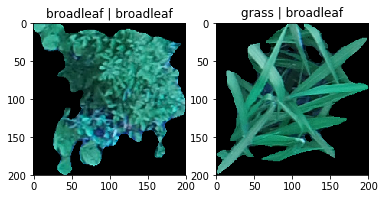

In [26]:
#Plot two images predict
index = np.flatnonzero(0 == train_Y)
index = np.random.choice(index, 1, replace=False)
prediction = nn.predict(train_X[index])

plt.subplot(1, 2, 1)
plt.title('{} | {}'.format(class_names[0], class_names[prediction[0]]))
plt.imshow(train_X[index].reshape(ROWS, COLS, CHANNELS).astype('uint8'))

index = np.flatnonzero(1 == train_Y)
index = np.random.choice(index, 1, replace=False)
prediction = nn.predict(train_X[index])

plt.subplot(1, 2, 2)
plt.title('{} | {}'.format(class_names[1], class_names[prediction[0]]))
plt.imshow(train_X[index].reshape(ROWS, COLS, CHANNELS).astype('uint8'))